In [1]:
import tensorflow as tf
import numpy as np
import os,math,re,sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #CPU Only

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'#GPU Running

import matplotlib.pylab as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
strategy = tf.distribute.MirroredStrategy(devices=None) #Use all available GPUs or CPU
print("REPLICAS:", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
REPLICAS: 1


2022-04-21 20:26:36.182522: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
IMG_SIZE = [224,224]
BATCH_SIZE = 16
EPOCHS = 13

LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def scheduler_epoch(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        learning_rate = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        learning_rate = LR_MAX
    else:
        learning_rate = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return learning_rate
                
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler_epoch, verbose=True)

In [21]:
DataSet_Path = '/Users/zhuzhirui/.keras/datasets/104_Flowers'
Train_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_train.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_train.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_train.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_train.tfrecord'
}

Val_Size_Choice = {
    192: DataSet_Path + '/jpeg-192x192_val.tfrecord',
    224: DataSet_Path + '/jpeg-224x224_val.tfrecord',
    311: DataSet_Path + '/jpeg-311x311_val.tfrecord',
    512: DataSet_Path + '/jpeg-512x512_val.tfrecord'
}

TrainSet_Path = Train_Size_Choice[IMG_SIZE[0]]
ValSet_Path = Val_Size_Choice[IMG_SIZE[0]]

CLASS = ['toad lily', 'love in the mist', 'monkshood', 'azalea', 'fritillary', 
         'silverbush', 'canterbury bells', 'stemless gentian', 'pink primrose', 'buttercup', 
         'poinsettia', 'desert-rose', 'bird of paradise', 'columbine', 'frangipani', 
         'sweet pea', 'siam tulip', 'great masterwort', 'hard-leaved pocket orchid', 'marigold', 
         'foxglove', 'wild pansy', 'windflower', 'daisy', 'tiger lily', 
         'purple coneflower', 'orange dahlia', 'globe-flower', 'lilac hibiscus', 'fire lily', 
         'balloon flower', 'iris', 'bishop of llandaff', 'yellow iris', 'garden phlox', 
         'alpine sea holly', 'geranium', 'pink quill', 'tree poppy', 'spear thistle', 
         'bromelia', 'common dandelion', 'sword lily', 'peruvian lily', 'carnation', 
         'cosmos', 'spring crocus', 'lotus', 'bolero deep blue', 'anthurium', 
         'rose', 'water lily', 'primula', 'blackberry lily', 'gaura', 
         'trumpet creeper', 'globe thistle', 'sweet william', 'snapdragon', 'mexican petunia', 
         'cyclamen ', 'petunia', 'gazania', 'king protea', 'blanket flower', 
         'common tulip', 'giant white arum lily', 'wild rose', 'morning glory', 'thorn apple', 
         'pincushion flower', 'tree mallow', 'canna lily', 'camellia', 'pink-yellow dahlia', 
         'bee balm', 'wild geranium', 'artichoke', 'black-eyed susan', 'ruby-lipped cattleya', 
         'clematis', 'prince of wales feathers', 'hibiscus', 'cautleya spicata', 'lenten rose', 
         'red ginger', "colt's foot", 'hippeastrum ', 'mallow', 'californian poppy', 
         'corn poppy', 'moon orchid', 'passion flower', 'grape hyacinth', 'japanese anemone', 
         'watercress', 'cape flower', 'osteospermum', 'barberton daisy', 'bougainvillea', 
         'magnolia', 'sunflower', 'daffodil', 'wallflower']

NUM_TRAINING_IMG = 12753
STEPS_PER_EPOCH = NUM_TRAINING_IMG // BATCH_SIZE
NUM_VALIDATION_IMG = 3712
VALIDATION_STEPS = -(-NUM_VALIDATION_IMG // BATCH_SIZE) #The "-(- // )" trick rounds up instead of down


In [5]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #JPEG --> Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.resize(image, IMG_SIZE) #image must be 3-D, so resize it
    return image

def read_tfrecord(example):
    image_feature_dict = {
        'image': tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_id': tf.io.FixedLenFeature([],tf.string)
    }
    example = tf.io.parse_single_example(example, image_feature_dict) #return a dict
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int64) #104 classes in[0,103]
    image_id = example['image_id'] 
    return image,label   #return a tuple

def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()

    if not ordered:
        ignore_order.deterministic = False # experimental_deterministic has been baned

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TrainSet_Path) #ordered default is False
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #Prepare later elements
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset(ValSet_Path, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() #cache files in memory
    dataset = dataset.prefetch(AUTO)
    return dataset


In [6]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training label examples:", label.numpy())
labelarray = label.numpy()
print(labelarray[0],type(labelarray[0]))
imagearray = image.numpy()
print(imagearray[0], type(imagearray[0]))

Training data shapes:
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
(16, 224, 224, 3) (16,)
Training label examples: [ 95   2 103  47  41  68  65  87  56  89  62  95  22  31  67  15]
95 <class 'numpy.int64'>
[[[0.3803922  0.5411765  0.30588236]
  [0.33333334 0.49803925 0.2509804 ]
  [0.26666668 0.427451   0.16862746]
  ...
  [0.21176472 0.34117648 0.11764707]
  [0.21568629 0.33333334 0.12156864]
  [0.21176472 0.32941177 0.1254902 ]]

 [[0.3803922  0.54901963 0.32941177]
  [0.3137255  0.48627454 0.24705884]
  [0.227451   0.3921569  0.14117648]
  ...
  [0.21176472 0.34117648 0.11764707]
  [0.21568629 0.33333334 0.12156864]
  [0.21176472 0.32941177 0.1254902 ]]

 [[0.37254903 0.54509807 0.34509805]
  [0.3137255  0.4901961  0.27450982]
  [0.227451   0.40000004 0.16862746]
  ...
  [0.21960786 0.34901962 0.1254902 ]
  [0.22352943 0.34117648 0.12941177]
  [0.21960786 0.3372549  0.13333334]]

 ...

 [[0.3019608  0.49803925 0.05490196]
  [0.25490198 0.45098042 0.01568628]
  [0.3019608  0.4941

(20, 224, 224, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[73 61 83 31 67 31 76 14 65 76 88 14 69 20 41 22 38 67 12 76]


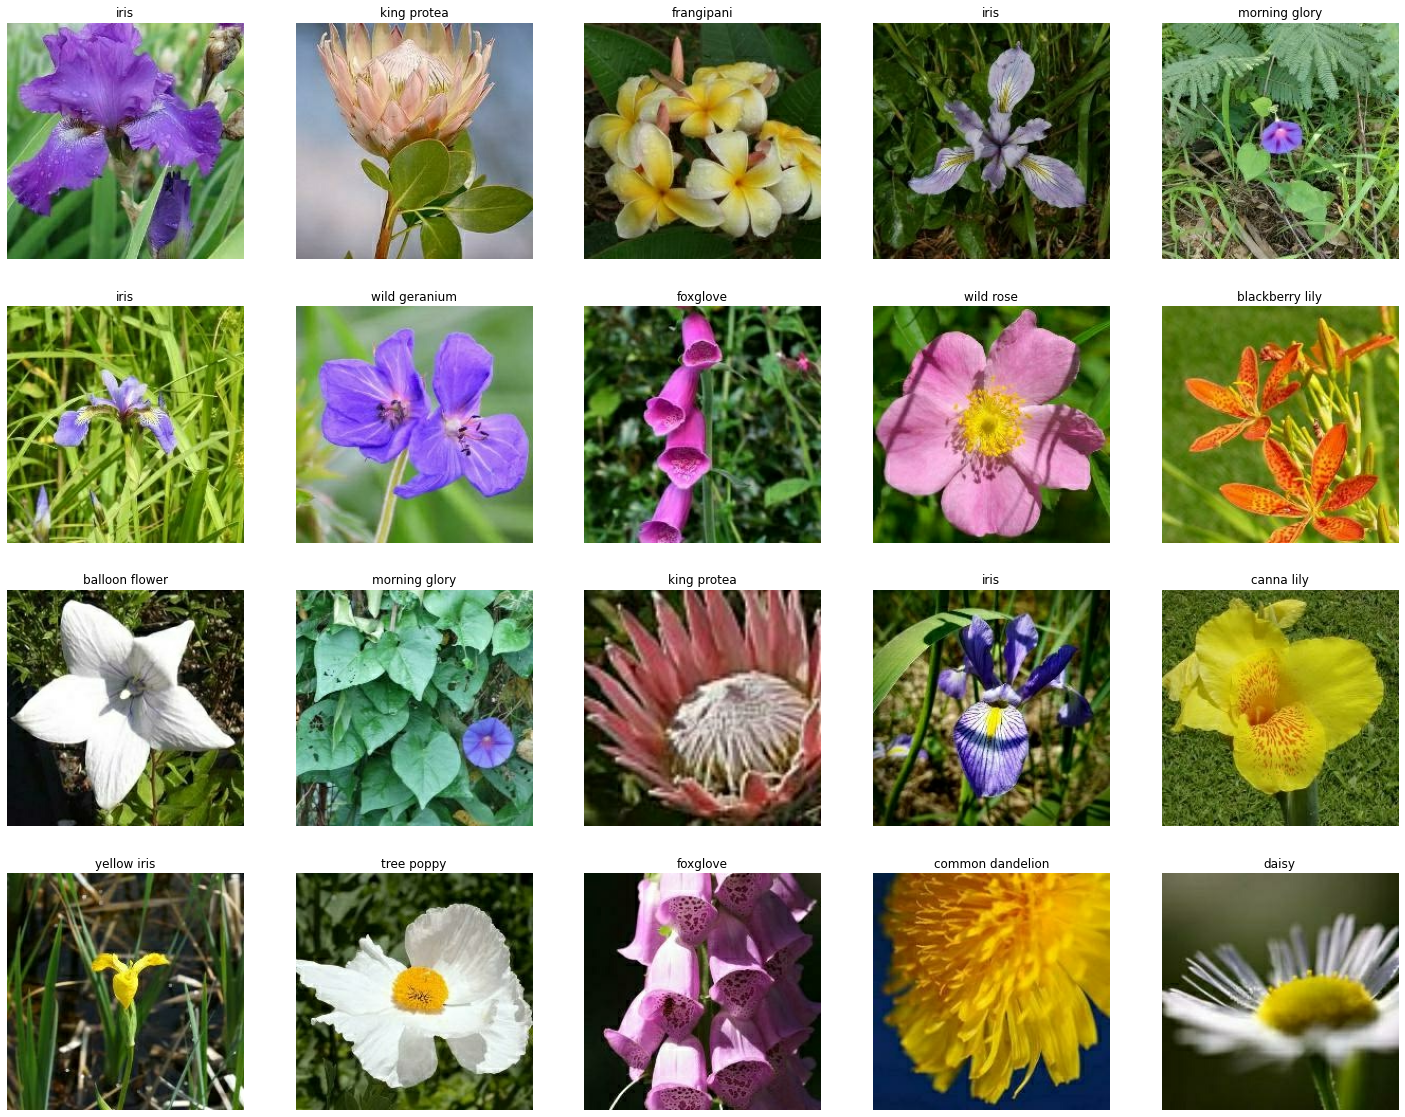

In [15]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
train_batch = iter(training_dataset)

for image, label in train_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(train_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASS[index])
  plt.axis("off")

2022-04-21 21:11:59.658196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(20, 224, 224, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[ 79  85   8 101  68  65  59  41 101   2  51 101  58  92   9  51  94  67
  79  87]


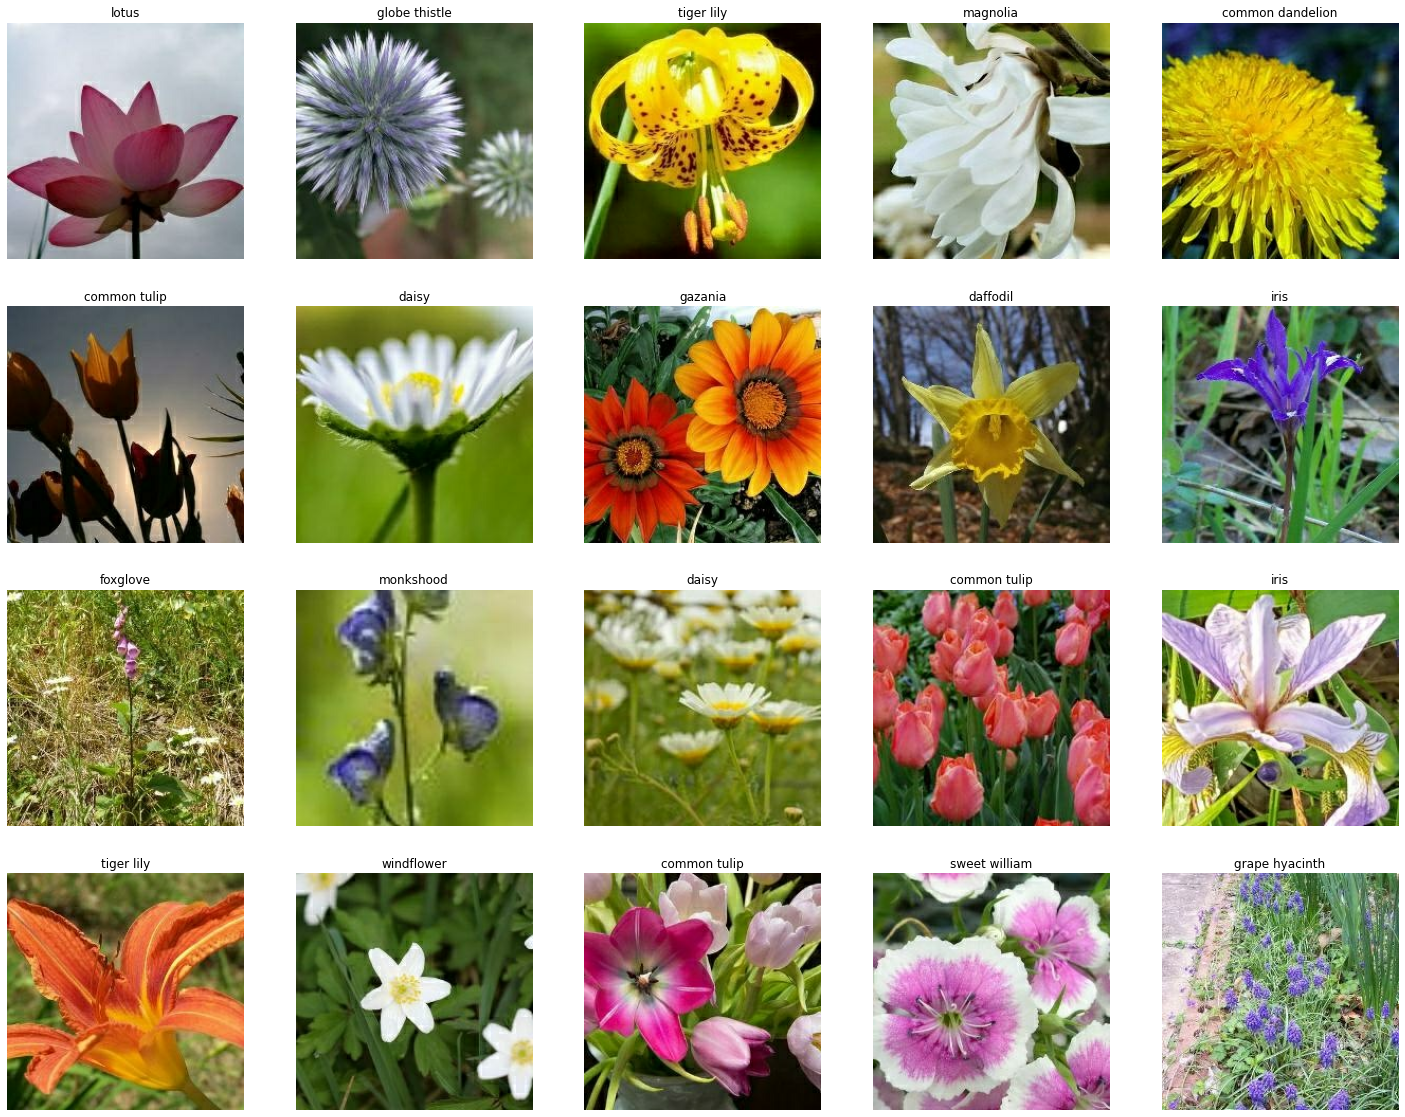

In [17]:
validation_dataset = get_validation_dataset()
validation_dataset = validation_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
validation_batch = iter(validation_dataset)

for image, label in validation_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(validation_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(25, 20)) #the size of whole figure
for i in range(20):
  ax = plt.subplot(4, 5, i+1) #the whole figure has 4 rows, 5 columns figures, this is i+1 figure
  #plt.imshow(image_batch[i].numpy().astype("uint8"))  #when image Tensor is the type of Uint8
  plt.imshow(image_batch[i].numpy())
  index = label_batch[i]  #5 classes in[0,4]
  plt.title(CLASS[index])
  plt.axis("off")

In [18]:
with strategy.scope():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=[*IMG_SIZE, 3]),  #224*224*3
            tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'), #[11,11,3,96]
            #[224, 224, 3] --> [54, 54, 96]
            tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu'), #[5, 5, 96, 256]
            #[54, 54, 96] --> [50, 50, 256]
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2), #[50, 50, 256] --> [25, 25, 256]
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'), #[3, 3, 256, 384]
            #[25, 25, 256] --> [23, 23, 384]
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2), #[23, 23, 384] --> [11, 11, 384]
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, activation='relu'), #[3, 3, 384, 384]
            #[11, 11, 384] --> [9, 9, 384]
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu'), #[3, 3, 384, 256]
            #[9, 9, 384] --> [7, 7, 256]
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2), #[7, 7, 256] --> [3, 3, 256]
            tf.keras.layers.Flatten(), #3 * 3 * 256 = 2304
            tf.keras.layers.Dense(4096, activation='relu'), #64 * 64
            tf.keras.layers.Dense(4096, activation='relu'), #64 * 64
            tf.keras.layers.Dense(len(CLASS), activation='softmax')
        ]
    )

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=1
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 256)       614656    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 384)       885120    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 384)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 384)         1

In [23]:
history = model.fit(
    get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
    validation_data=get_validation_dataset(), validation_steps=VALIDATION_STEPS,
    callbacks=[lr_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/13


2022-04-22 10:26:27.511995: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - ETA: 0s - loss: 3.6826 - sparse_categorical_accuracy: 0.1218

2022-04-22 10:40:23.875689: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 908s 1s/step - loss: 3.6826 - sparse_categorical_accuracy: 0.1218 - val_loss: 3.2197 - val_sparse_categorical_accuracy: 0.1805 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 8.2e-05.
Epoch 2/13
797/797 [==============================] - ETA: 0s - loss: 3.1042 - sparse_categorical_accuracy: 0.2027

2022-04-22 10:55:28.957693: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 905s 1s/step - loss: 3.1042 - sparse_categorical_accuracy: 0.2027 - val_loss: 3.0762 - val_sparse_categorical_accuracy: 0.2139 - lr: 8.2000e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.760000000000002e-05.
Epoch 3/13
797/797 [==============================] - ETA: 0s - loss: 2.7445 - sparse_categorical_accuracy: 0.2709

2022-04-22 11:10:30.392762: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 899s 1s/step - loss: 2.7445 - sparse_categorical_accuracy: 0.2709 - val_loss: 2.6414 - val_sparse_categorical_accuracy: 0.3036 - lr: 6.7600e-05

Epoch 4: LearningRateScheduler setting learning rate to 5.608000000000001e-05.
Epoch 4/13
797/797 [==============================] - ETA: 0s - loss: 2.4556 - sparse_categorical_accuracy: 0.3343

2022-04-22 11:25:19.344794: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 891s 1s/step - loss: 2.4556 - sparse_categorical_accuracy: 0.3343 - val_loss: 2.4969 - val_sparse_categorical_accuracy: 0.3324 - lr: 5.6080e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.686400000000001e-05.
Epoch 5/13
797/797 [==============================] - ETA: 0s - loss: 2.2127 - sparse_categorical_accuracy: 0.3933

2022-04-22 11:40:21.075346: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 899s 1s/step - loss: 2.2127 - sparse_categorical_accuracy: 0.3933 - val_loss: 2.3190 - val_sparse_categorical_accuracy: 0.3761 - lr: 4.6864e-05

Epoch 6: LearningRateScheduler setting learning rate to 3.949120000000001e-05.
Epoch 6/13
797/797 [==============================] - ETA: 0s - loss: 2.0070 - sparse_categorical_accuracy: 0.4452

2022-04-22 11:55:25.203008: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 905s 1s/step - loss: 2.0070 - sparse_categorical_accuracy: 0.4452 - val_loss: 2.2815 - val_sparse_categorical_accuracy: 0.3987 - lr: 3.9491e-05

Epoch 7: LearningRateScheduler setting learning rate to 3.359296000000001e-05.
Epoch 7/13
797/797 [==============================] - ETA: 0s - loss: 1.8306 - sparse_categorical_accuracy: 0.4895

2022-04-22 12:10:04.239786: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 880s 1s/step - loss: 1.8306 - sparse_categorical_accuracy: 0.4895 - val_loss: 2.1866 - val_sparse_categorical_accuracy: 0.4348 - lr: 3.3593e-05

Epoch 8: LearningRateScheduler setting learning rate to 2.887436800000001e-05.
Epoch 8/13
797/797 [==============================] - ETA: 0s - loss: 1.6716 - sparse_categorical_accuracy: 0.5275

2022-04-22 12:24:17.978796: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 852s 1s/step - loss: 1.6716 - sparse_categorical_accuracy: 0.5275 - val_loss: 2.1171 - val_sparse_categorical_accuracy: 0.4585 - lr: 2.8874e-05

Epoch 9: LearningRateScheduler setting learning rate to 2.509949440000001e-05.
Epoch 9/13
797/797 [==============================] - ETA: 0s - loss: 1.5064 - sparse_categorical_accuracy: 0.5714

2022-04-22 12:38:27.799956: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 850s 1s/step - loss: 1.5064 - sparse_categorical_accuracy: 0.5714 - val_loss: 2.1071 - val_sparse_categorical_accuracy: 0.4526 - lr: 2.5099e-05

Epoch 10: LearningRateScheduler setting learning rate to 2.207959552000001e-05.
Epoch 10/13
797/797 [==============================] - ETA: 0s - loss: 1.3704 - sparse_categorical_accuracy: 0.6074

2022-04-22 12:52:38.455278: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 850s 1s/step - loss: 1.3704 - sparse_categorical_accuracy: 0.6074 - val_loss: 2.1401 - val_sparse_categorical_accuracy: 0.4623 - lr: 2.2080e-05

Epoch 11: LearningRateScheduler setting learning rate to 1.9663676416000005e-05.
Epoch 11/13
797/797 [==============================] - ETA: 0s - loss: 1.2426 - sparse_categorical_accuracy: 0.6401

2022-04-22 13:06:48.946302: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 850s 1s/step - loss: 1.2426 - sparse_categorical_accuracy: 0.6401 - val_loss: 2.1400 - val_sparse_categorical_accuracy: 0.4669 - lr: 1.9664e-05

Epoch 12: LearningRateScheduler setting learning rate to 1.7730941132800006e-05.
Epoch 12/13
797/797 [==============================] - ETA: 0s - loss: 1.1113 - sparse_categorical_accuracy: 0.6815

2022-04-22 13:21:00.607740: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 851s 1s/step - loss: 1.1113 - sparse_categorical_accuracy: 0.6815 - val_loss: 2.2637 - val_sparse_categorical_accuracy: 0.4574 - lr: 1.7731e-05

Epoch 13: LearningRateScheduler setting learning rate to 1.6184752906240005e-05.
Epoch 13/13
797/797 [==============================] - ETA: 0s - loss: 0.9995 - sparse_categorical_accuracy: 0.7113

2022-04-22 13:35:14.258839: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


797/797 [==============================] - 854s 1s/step - loss: 0.9995 - sparse_categorical_accuracy: 0.7113 - val_loss: 2.3169 - val_sparse_categorical_accuracy: 0.4669 - lr: 1.6185e-05


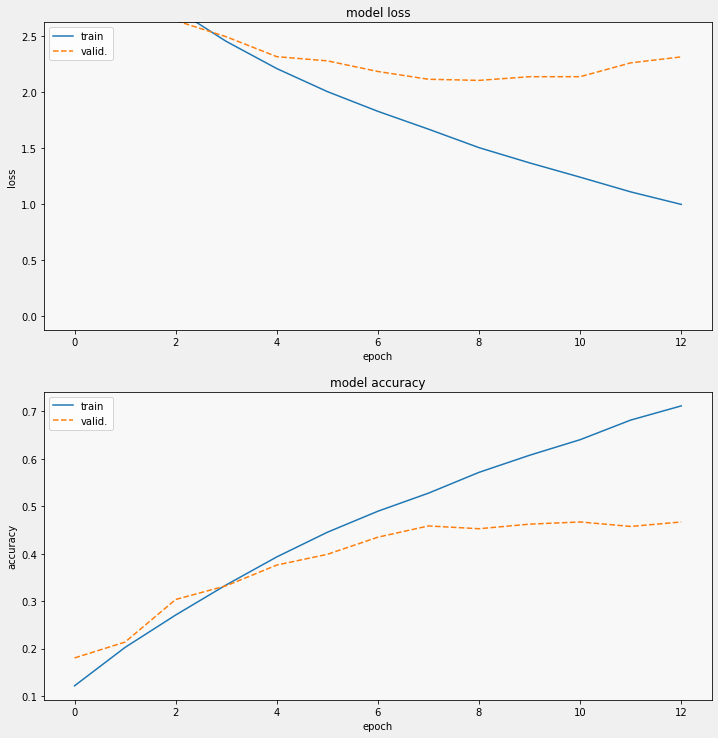

In [24]:
def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation, '--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
    
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211, ylim=[0,2.5])
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 'accuracy', 212)


In [25]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMG))).numpy() # get everything as one batch
cm_probabilities = model.predict(images_ds, steps=VALIDATION_STEPS)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)


2022-04-22 14:56:44.084134: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Correct   labels:  (3712,) [79 85  8 ... 86 31 31]
Predicted labels:  (3712,) [79 49  8 ...  9 31 31]


/Users/zhuzhirui/opt/anaconda3/envs/Pure_TensorFlow_2_8/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


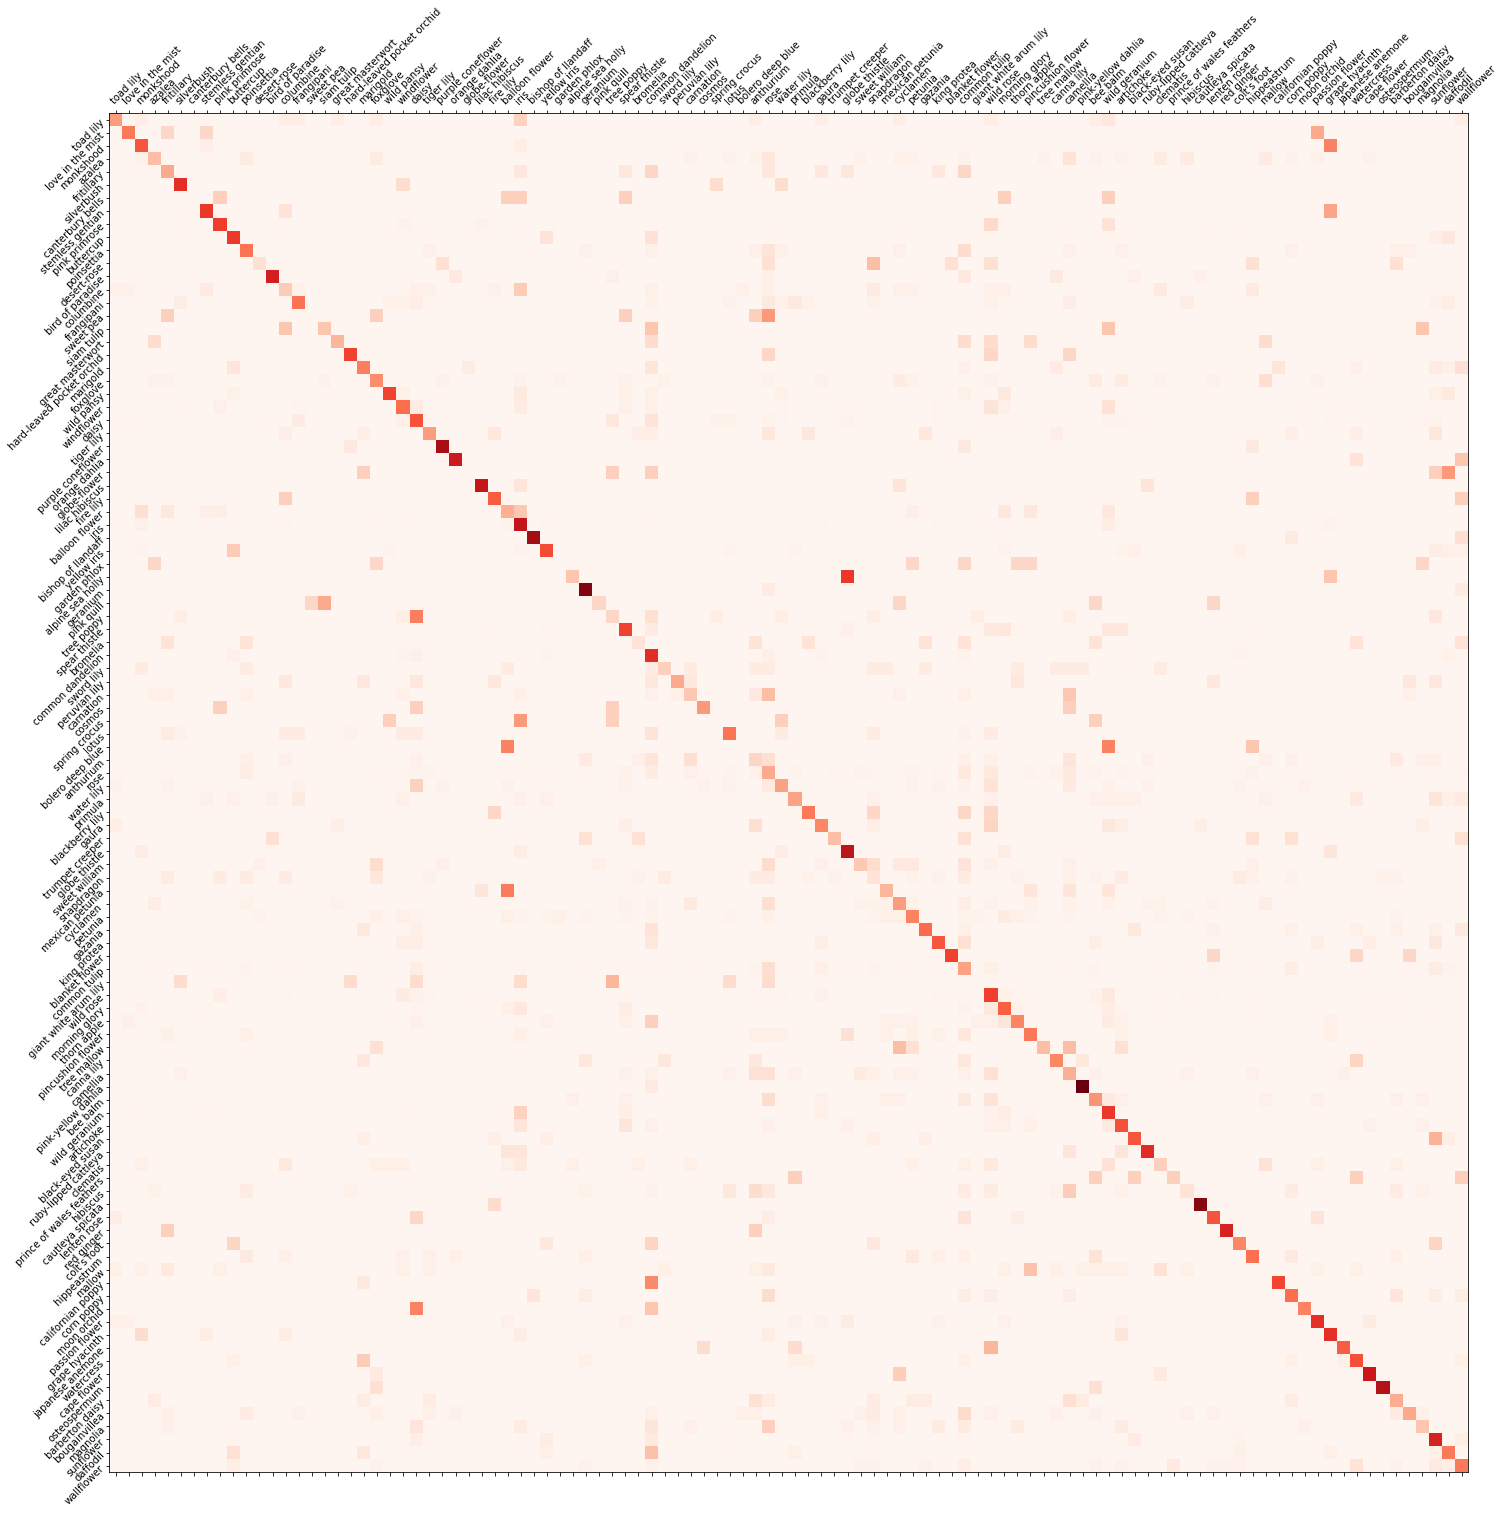

f1 score: 0.395, precision: 0.412, recall: 0.404


In [31]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(25,25))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASS)))
    ax.set_xticklabels(CLASS)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASS)))
    ax.set_yticklabels(CLASS)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASS)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASS)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASS)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASS)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))